<a href="https://colab.research.google.com/github/Aravinda89/Image-Classificatio-from-Scratch/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install fastai==2.0.15
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.16
# !pip install fastai --upgrade

! [ -e /content ] && pip install -Uqq fastai 

# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 2.5 MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

In [4]:
# Load data
path = untar_data(URLs.MNIST)

In [5]:
items = get_image_files(path)

In [6]:
items[0]

Path('/root/.fastai/data/mnist_png/testing/1/9923.png')

In [7]:
items[:3]

(#3) [Path('/root/.fastai/data/mnist_png/testing/1/9923.png'),Path('/root/.fastai/data/mnist_png/testing/1/3433.png'),Path('/root/.fastai/data/mnist_png/testing/1/6224.png')]

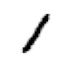

In [9]:
# Visualize image
im = PILImageBW.create(items[0])
im.show()

In [10]:
# Split train/test set
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [11]:
splits = splits(items)

In [12]:
splits[0][:5]

[10000, 10001, 10002, 10003, 10004]

In [13]:
len(splits[0])

60000

In [14]:
len(splits[1])

10000

In [15]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], 
                  splits=splits)

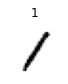

In [16]:
show_at(dsrc.train,5)

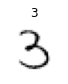

In [17]:
show_at(dsrc.valid,5000)

In [18]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [19]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [20]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

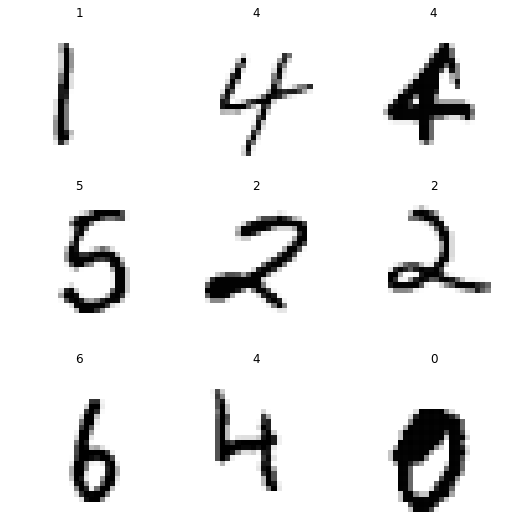

In [21]:
dls.show_batch()

In [22]:
xb, yb = dls.one_batch()

In [23]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [24]:
dls.c

10

Model

In [25]:
def conv(ni, nf): 
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [26]:
def bn(nf): 
  return nn.BatchNorm2d(nf)

In [27]:
def ReLU(): 
  return nn.ReLU(inplace=False)

In [28]:
model = nn.Sequential(
                      conv(1, 8),
                      bn(8),
                      ReLU(),
                      conv(8, 16),
                      bn(16),
                      ReLU(),
                      conv(16,32),
                      bn(32),
                      ReLU(),
                      conv(32, 16),
                      bn(16),
                      ReLU(),
                      conv(16, 10),
                      bn(10),
                      Flatten()
)

In [29]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(full=False)
)

In [30]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [31]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________

Learning Rate finder

SuggestedLRs(valley=0.007585775572806597)

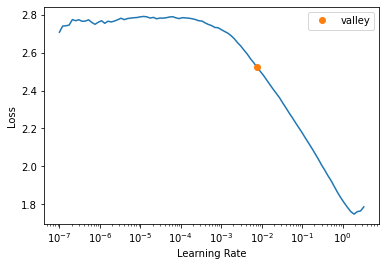

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(3, lr_max=0.007585775572806597)

epoch,train_loss,valid_loss,accuracy,time
0,0.223356,0.102135,0.975900,02:02
1,0.106188,0.082468,0.977100,02:01
2,0.070597,0.046878,0.987400,02:01


In [ ]:
learn.fit_one_cycle(3, lr_max=0.007585775572806597)
